## Importing neccessary library

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose

# dickey fuller test for stationarity check
from statsmodels.tsa.stattools import adfuller,acf,pacf

from statsmodels.tsa.statespace.tools import diff

# pip install pmdarima
from pmdarima.arima import auto_arima

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

## Loading data

In [2]:
sales=pd.read_csv(r"K:\Desktop\NIIT\tables\DS3_C1_S4_SuperstoreSales_Data_Challenge.csv",parse_dates=['Order Date'])
sales.set_index('Order Date',inplace=True)
sales.sort_index(inplace=True)

## Resampling

In [3]:
sales_M=sales.Sales.resample('M').mean()

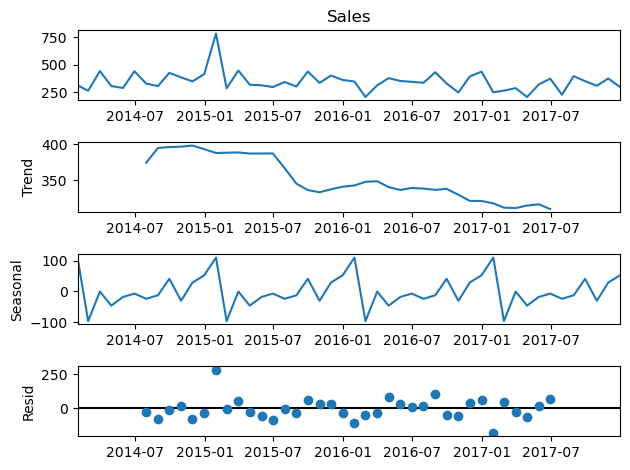

In [4]:
seasonal_decompose(sales_M).plot()
plt.show()

## All components of TS are present

In [5]:
def checkstationarity(data):
    pvalue=adfuller(data)[1]
    print(pvalue)
    if pvalue<0.05:
        msg='pvalue={}. Data is stationary, proceed to model building'.format(pvalue)
    else:
        msg='pvalue={} Data is not stationary, Make the data stationary before model building'.format(pvalue)
    
    return msg

In [6]:
checkstationarity(sales_M)

9.093398510006677e-10


'pvalue=9.093398510006677e-10. Data is stationary, proceed to model building'

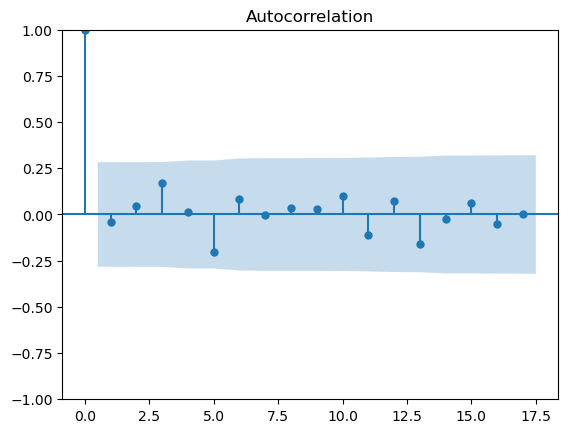

In [7]:
plot_acf(sales_M)
plt.show()

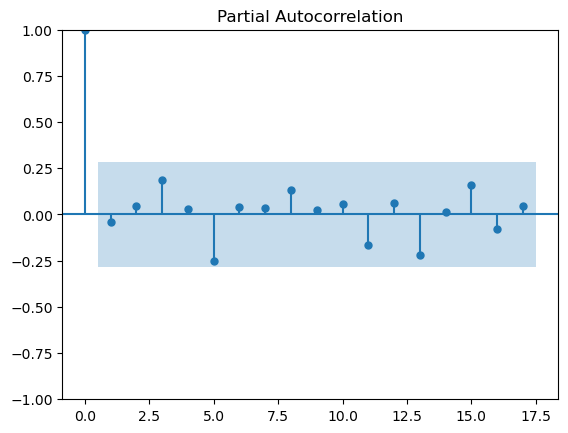

In [8]:
plot_pacf(sales_M)
plt.show()

In [9]:
import itertools
import statsmodels.api as sm

def find_best_arima_pq(data, p_range, q_range):
    p_range = list(range(1,p_range))
    q_range = list(range(1,q_range))
    
    best_aic = float('inf')
    best_model = None    
    for p, q in itertools.product(p_range, q_range):
        try:
            model = sm.tsa.ARIMA(data, order=(p,1, q))
            results = model.fit()
            aic = results.aic
            if aic < best_aic:
                best_aic = aic
                best_model = model
                p=p
                q=q
        except:
            continue 
    best_results = best_model.fit()
    return best_results,p,q

model,p,q=find_best_arima_pq(sales_M,5,5)

In [10]:
s=int(len(sales_M)*0.7)
a=int(len(sales_M)*0.3)

In [11]:
start = s 
end = s + a  - 1

In [12]:
predicts=model.predict(start,end)
df_rs={'actual':sales_M[start:end+1].values,'Predicts':predicts.values}#.reshape(-1,1)}
df_rs=pd.DataFrame(df_rs)

In [13]:
# LJung-Box test
pvalue = sm.stats.acorr_ljungbox(model.resid,lags=[1],return_df=True)['lb_pvalue'].values
print (pvalue)
if pvalue < 0.05:
    print("Reject H0. Bad model")
else:
    print("Fail-to-Reject H0. Hence the selected model is Good model")
    

[0.743644]
Fail-to-Reject H0. Hence the selected model is Good model


<AxesSubplot: >

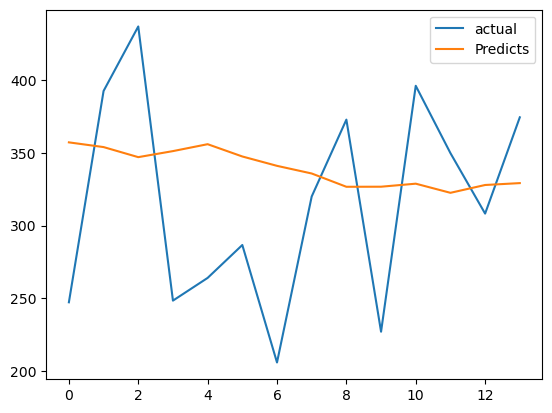

In [14]:
df_rs.plot()

In [15]:
p=4;q=4;d=1;
P=1;Q=0;D=1;
model2 = sm.tsa.statespace.SARIMAX(sales['Sales'],order=(p,d,q),seasonal_order=(P,D,Q,12)).fit()

In [16]:
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               Sales   No. Observations:                 2121
Model:             SARIMAX(4, 1, 4)x(1, 1, [], 12)   Log Likelihood              -16512.946
Date:                             Thu, 02 Mar 2023   AIC                          33045.892
Time:                                     10:37:18   BIC                          33102.427
Sample:                                          0   HQIC                         33066.595
                                            - 2121                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.9219      0.032    -60.343      0.000      -1.984      -1.859
ar.L2         -1.8520      0.064    -29.132      0.000      -1.977      -1.727
ar.L3         -0.9075      0.064    -14.164      0.000      -1.033      -0.782
ar.L4         -0.0297      0.033     -0.912      0.362      -0.094       0.034
ma.L1          0.9999      3.106      0.322      0.748      -5.088       7.088
ma.L2         -0.0009      3.106     -0.000      1.000      -6.088       6.086
ma.L3         -0.9999      3.101     -0.322      0.747      -7.078       5.078
ma.L4         -0.9991      0.018    -54.564      0.000      -1.035      -0.963
ar.S.L12      -0.4699      0.017    -27.139      0.000      -0.504      -0.436
sigma2      4.778e+05   3.25e-05   1.47e+10      0.000    4.78e+05    4.78e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):              7666.70
Prob(Q):                              0.75   Prob(JB):                         0.00
Heteroskedasticity (H):               0.66   Skew:                             1.82
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.22e+27. Standard errors may be unstable.
"""

In [17]:
# LJung-Box test
pvalue = sm.stats.acorr_ljungbox(model2.resid,lags=[1],return_df=True)['lb_pvalue'].values
print (pvalue)
if pvalue < 0.05:
    print("Reject H0. Bad model")
else:
    print("Fail-to-Reject H0. Hence the selected model is Good model")
    

[0.96916626]
Fail-to-Reject H0. Hence the selected model is Good model


In [18]:
predicts=model2.predict(start,end)

In [19]:
df_rs={'actual':sales_M[start:end+1].values,'Predicts':predicts.values}#.reshape(-1,1)}

In [20]:
df_rs=pd.DataFrame(df_rs)
df_rs

,actual,Predicts
0,247.345354,199.487181
1,392.390479,611.272568
2,436.651369,72.741202
3,248.501333,142.413082
4,264.089900,454.789274
5,286.669600,-75.408294
6,206.044502,378.152524
7,319.953928,235.502367
8,372.717386,365.473673
9,227.173500,432.851461


<AxesSubplot: >

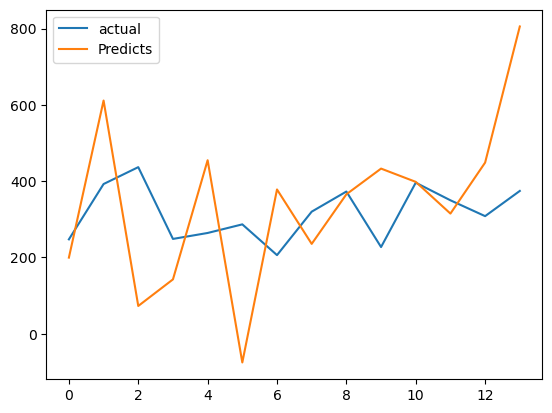

In [21]:
df_rs.plot()

## Conclusion:
he ARIMA model is a stationary model that can handle the autocorrelation and trend in time series data. However, the ARIMA model does not take seasonality into account, which can lead to inaccurate forecasts for data that exhibit a seasonal pattern.

On the other hand, the SARIMA model is a seasonal version of the ARIMA model that takes seasonality into account. The SARIMA model can handle both the autocorrelation and trend in the data, as well as the seasonal pattern. However, the SARIMA model can be more complex to tune and fit, and requires more data than the ARIMA model to produce accurate forecasts.